<h3>AI Prevalence - AI ratio over time</h3>

/tmp/ipykernel_135400/2686834703.py:192: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.94])


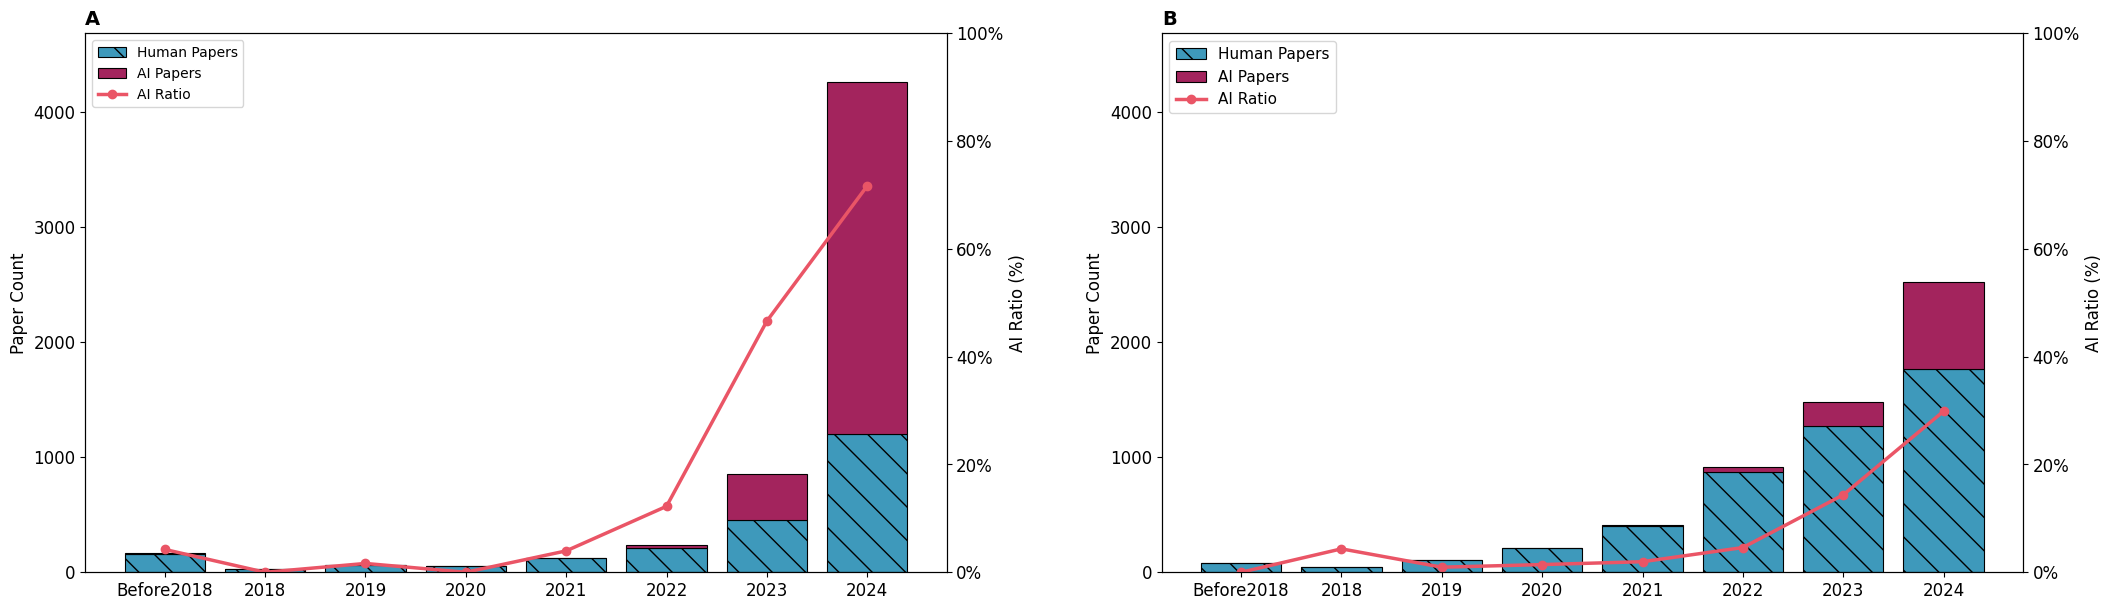

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as mtick
from matplotlib import rcParams

plt.style.use('default')
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans', 'Liberation Sans']
rcParams['font.size'] = 12

COLOR_HUMAN = '#3e99bb'   
COLOR_AI    = '#a3245d'  
COLOR_LINE  = "#ea5566"  

def process_vote_data(
    paper_pkl, vote_pkl, sapling_pkl, zerogpt_pkl, checkgpt_pkl,
    min_threshold=10
):
    df_paper    = pd.read_pickle(paper_pkl)
    df_vote     = pd.read_pickle(vote_pkl)
    df_sapling  = pd.read_pickle(sapling_pkl)
    df_zerogpt  = pd.read_pickle(zerogpt_pkl)
    df_checkgpt = pd.read_pickle(checkgpt_pkl)

    df_paper = df_paper.dropna(subset=['publication_date'])
    df_paper['publication_date'] = (
        df_paper['publication_date']
        .astype(str)
        .str.replace('\u200e', '', regex=False)
        .str.strip()
    )
    df_paper['publication_date'] = pd.to_numeric(
        df_paper['publication_date'], errors='coerce'
    )
    df_paper = df_paper.dropna(subset=['publication_date'])
    df_paper['year'] = df_paper['publication_date'].astype(float).astype(int)

    df_paper['year_bin'] = np.where(df_paper['year'] < 2018, 2017, df_paper['year'])

    df_all = pd.merge(df_paper, df_vote,
                      left_on='id', right_on='paper_id', how='left')
    df_all['is_ai_final'] = df_all['final_decision'].apply(
        lambda x: 1 if x == 'AI' else 0
    )

    group_vote = df_all.groupby('year_bin').agg(
        total_papers=('id', 'count'),
        ai_papers=('is_ai_final', 'sum')
    ).reset_index()

    group_vote['human_papers'] = (
        group_vote['total_papers'] - group_vote['ai_papers']
    )
    group_vote['ai_ratio'] = (
        group_vote['ai_papers'] / group_vote['total_papers']
    )

    group_vote = group_vote[group_vote['total_papers'] >= min_threshold]

    group_vote = group_vote.set_index('year_bin').sort_index()

    return group_vote

#############################
# Import File Path
#############################

good_paper_pkl    = "data/norm/dataset/pkl/papers.pkl"
good_vote_pkl     = "data/norm/dataset/pkl/vote_results.pkl"
good_sapling_pkl  = "data/norm/dataset/pkl/sapling_results.pkl"
good_zerogpt_pkl  = "data/norm/dataset/pkl/zerogpt_results.pkl"
good_checkgpt_pkl = "data/norm/dataset/pkl/checkGPT.pkl"

bad_paper_pkl    = "data/pred/dataset/pkl/papers.pkl"
bad_vote_pkl     = "data/pred/dataset/pkl/vote_results.pkl"
bad_sapling_pkl  = "data/pred/dataset/pkl/sapling_results.pkl"
bad_zerogpt_pkl  = "data/pred/dataset/pkl/zerogpt_results.pkl"
bad_checkgpt_pkl = "data/pred/dataset/pkl/checkGPT.pkl"

MIN_PAPERS_THRESHOLD = 10  

good_group_vote = process_vote_data(
    good_paper_pkl, good_vote_pkl, good_sapling_pkl,
    good_zerogpt_pkl, good_checkgpt_pkl,
    min_threshold=MIN_PAPERS_THRESHOLD
)
bad_group_vote = process_vote_data(
    bad_paper_pkl, bad_vote_pkl, bad_sapling_pkl,
    bad_zerogpt_pkl, bad_checkgpt_pkl,
    min_threshold=MIN_PAPERS_THRESHOLD
)

max_good_year = good_group_vote.index.max() if not good_group_vote.empty else 2017
max_bad_year  = bad_group_vote.index.max()  if not bad_group_vote.empty  else 2017
final_max_year = min(max_good_year, max_bad_year)

all_years = list(range(2017, final_max_year + 1))
good_group_vote = good_group_vote.reindex(all_years, fill_value=0)
bad_group_vote  = bad_group_vote.reindex(all_years, fill_value=0)

x_labels     = ["Before2018" if y == 2017 else str(y) for y in all_years]
x_positions  = np.arange(len(all_years))
common_y_max = max(
    good_group_vote['total_papers'].max(),
    bad_group_vote['total_papers'].max()
)

fig, (ax_left, ax_right) = plt.subplots(
    1, 2, figsize=(25, 7), sharex=True,
    gridspec_kw={'wspace': 0.25}
)

mask_bad = bad_group_vote['total_papers'] > 0
ax_left.bar(
    x_positions[mask_bad],
    bad_group_vote['human_papers'][mask_bad],
    label='Human Papers',
    color=COLOR_HUMAN,
    edgecolor='black', linewidth=0.8, hatch='\\'
)
ax_left.bar(
    x_positions[mask_bad],
    bad_group_vote['ai_papers'][mask_bad],
    bottom=bad_group_vote['human_papers'][mask_bad],
    label='AI Papers',
    color=COLOR_AI,
    edgecolor='black', linewidth=0.8
)

ax_left.set_xticks(x_positions)
ax_left.set_xticklabels(x_labels, rotation=0)
ax_left.set_ylim(0, common_y_max * 1.1)
ax_left.set_title('A', loc='left', fontsize=14, fontweight='bold')
ax_left.set_ylabel('Paper Count')

ax_left_twin = ax_left.twinx()
ax_left_twin.plot(
    x_positions[mask_bad],
    bad_group_vote['ai_ratio'][mask_bad],
    color=COLOR_LINE, marker='o',
    markersize=6, linewidth=2.5, label='AI Ratio'
)
ax_left_twin.set_ylim(0, 1.0)
ax_left_twin.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax_left_twin.set_ylabel('AI Ratio (%)')

lines1, labels1 = ax_left.get_legend_handles_labels()
lines2, labels2 = ax_left_twin.get_legend_handles_labels()
ax_left.legend(lines1 + lines2, labels1 + labels2,
               loc='upper left', fontsize=10)

mask_good = good_group_vote['total_papers'] > 0
ax_right.bar(
    x_positions[mask_good],
    good_group_vote['human_papers'][mask_good],
    label='Human Papers',
    color=COLOR_HUMAN,
    edgecolor='black', linewidth=0.8, hatch='\\'
)
ax_right.bar(
    x_positions[mask_good],
    good_group_vote['ai_papers'][mask_good],
    bottom=good_group_vote['human_papers'][mask_good],
    label='AI Papers',
    color=COLOR_AI,
    edgecolor='black', linewidth=0.8
)

ax_right.set_xticks(x_positions)
ax_right.set_xticklabels(x_labels, rotation=0)
ax_right.set_ylim(0, common_y_max * 1.1)
ax_right.set_title('B', loc='left', fontsize=14, fontweight='bold')
ax_right.set_ylabel('Paper Count')

ax_right_twin = ax_right.twinx()
ax_right_twin.plot(
    x_positions[mask_good],
    good_group_vote['ai_ratio'][mask_good],
    color=COLOR_LINE, marker='o',
    markersize=6, linewidth=2.5, label='AI Ratio'
)
ax_right_twin.set_ylim(0, 1.0) 
ax_right_twin.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax_right_twin.set_ylabel('AI Ratio (%)')

lines1, labels1 = ax_right.get_legend_handles_labels()
lines2, labels2 = ax_right_twin.get_legend_handles_labels()
ax_right.legend(lines1 + lines2, labels1 + labels2,
                loc='upper left', fontsize=11)

plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.savefig('figure/temporal.png',
            dpi=300, bbox_inches='tight')
plt.show()

Z-test: AI Proportion

In [9]:
from statsmodels.stats.proportion import proportions_ztest
import numpy as np

# Z-test: AI Proportion

ai_pred = bad_group_vote['ai_papers'].sum()
n_pred  = bad_group_vote['total_papers'].sum()

ai_good = good_group_vote['ai_papers'].sum()
n_good  = good_group_vote['total_papers'].sum()

p_pred = ai_pred / n_pred
p_good = ai_good / n_good

# single-side z-test：H0: p_pred <= p_good, H1: p_pred > p_good
count = np.array([ai_pred, ai_good])
nobs  = np.array([n_pred,  n_good])

zstat, pval = proportions_ztest(count, nobs, alternative='larger')

# Cohen's h
h = 2 * np.arcsin(np.sqrt(p_pred)) - 2 * np.arcsin(np.sqrt(p_good))
h_abs = abs(h)

print(f"Predatory: {ai_pred}/{n_pred} = {p_pred:.3%}")
print(f"Regular:   {ai_good}/{n_good} = {p_good:.3%}")
print(f"Z-statistic = {zstat:.3f}")
print(f"p (one-sided, pred>good) = {pval:.3e}")

print(f"Cohen's h = {h:.3f} (|h|={h_abs:.3f})")


Predatory: 3493/5787 = 60.359%
Regular:   1022/5769 = 17.715%
Z-statistic = 46.978
p (one-sided, pred>good) = 0.000e+00
Cohen's h = 0.911 (|h|=0.911)


Annual Z-Test: AI Ratio: Pred vs Regular AI 

In [10]:
from statsmodels.stats.proportion import proportions_ztest

print("=== Annual Z-Test: AI Ratio (Predatory > Regular) ===")

for year in all_years:
    ai_pred = bad_group_vote.loc[year, 'ai_papers']
    n_pred  = bad_group_vote.loc[year, 'total_papers']
    ai_good = good_group_vote.loc[year, 'ai_papers']
    n_good  = good_group_vote.loc[year, 'total_papers']
    
    if n_pred == 0 or n_good == 0:
        continue

    count = np.array([ai_pred, ai_good])
    nobs  = np.array([n_pred,  n_good])
    zstat, pval = proportions_ztest(count, nobs, alternative='larger')
    
    year_label = "Before2018" if year == 2017 else str(year)
    print(f"{year_label}: pred = {ai_pred}/{n_pred} ({ai_pred / n_pred:.1%}), "
          f"reg = {ai_good}/{n_good} ({ai_good / n_good:.1%}) | "
          f"z = {zstat:.2f}, p = {pval:.5f}")


=== Annual Z-Test: AI Ratio (Predatory > Regular) ===
Before2018: pred = 7/165 (4.2%), reg = 0/81 (0.0%) | z = 1.88, p = 0.03001
2018: pred = 0/32 (0.0%), reg = 2/46 (4.3%) | z = -1.19, p = 0.88395
2019: pred = 1/61 (1.6%), reg = 1/106 (0.9%) | z = 0.40, p = 0.34528
2020: pred = 0/53 (0.0%), reg = 3/210 (1.4%) | z = -0.88, p = 0.80925
2021: pred = 5/126 (4.0%), reg = 8/408 (2.0%) | z = 1.28, p = 0.10062
2022: pred = 29/237 (12.2%), reg = 42/915 (4.6%) | z = 4.36, p = 0.00001
2023: pred = 398/854 (46.6%), reg = 213/1483 (14.4%) | z = 17.08, p = 0.00000
2024: pred = 3053/4259 (71.7%), reg = 753/2520 (29.9%) | z = 33.52, p = 0.00000


<h3>Structural Shift - Publication Count Change</h3>

In [14]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
import statsmodels.api as sm

# Split data into pre-2022 and post-2022
cutoff = 2022
pred_pre  = bad_group_vote.loc[bad_group_vote.index < cutoff, 'total_papers']
pred_post = bad_group_vote.loc[bad_group_vote.index >= cutoff, 'total_papers']
norm_pre  = good_group_vote.loc[good_group_vote.index < cutoff, 'total_papers']
norm_post = good_group_vote.loc[good_group_vote.index >= cutoff, 'total_papers']

print("=== Basic counts ===")
print(f"Predatory pre-2022: {pred_pre.sum()} papers across {len(pred_pre)} years")
print(f"Predatory post-2022: {pred_post.sum()} papers across {len(pred_post)} years")
print(f"Normal pre-2022: {norm_pre.sum()} papers across {len(norm_pre)} years")
print(f"Normal post-2022: {norm_post.sum()} papers across {len(norm_post)} years")

# Calculate year-over-year growth
def calc_growth(series):
    return series.pct_change().dropna()  # year-over-year growth rate

pred_growth_pre  = calc_growth(pred_pre)
pred_growth_post = calc_growth(pred_post)
norm_growth_pre  = calc_growth(norm_pre)
norm_growth_post = calc_growth(norm_post)

print("\n=== Mean growth rate ===")
print(f"Predatory pre-2022 mean growth: {pred_growth_pre.mean():.2%}")
print(f"Predatory post-2022 mean growth: {pred_growth_post.mean():.2%}")
print(f"Normal pre-2022 mean growth: {norm_growth_pre.mean():.2%}")
print(f"Normal post-2022 mean growth: {norm_growth_post.mean():.2%}")

# t-tests: pre vs post growth rate differences
print("\n=== T-tests (pre vs post) ===")
t_pred, p_pred = ttest_ind(pred_growth_pre, pred_growth_post, equal_var=False, nan_policy='omit')
t_norm, p_norm = ttest_ind(norm_growth_pre, norm_growth_post, equal_var=False, nan_policy='omit')

print(f"Predatory: t={t_pred:.2f}, p={p_pred:.3e}")
print(f"Normal   : t={t_norm:.2f}, p={p_norm:.3e}")

# Optional: Interrupted Time Series Regression (ITS)
def run_its(series, cutoff):
    """
    Simple ITS regression:
    y = β0 + β1*time + β2*post + β3*time*post
    post = 0 (pre-2022), 1 (post-2022)
    """
    df = pd.DataFrame({'y': series.values, 'year': series.index})
    df['time'] = np.arange(len(df))
    df['post'] = (df['year'] >= cutoff).astype(int)
    df['time_post'] = df['time'] * df['post']

    X = sm.add_constant(df[['time','post','time_post']])
    model = sm.OLS(df['y'], X).fit()
    return model

print("\n=== Interrupted Time Series Regression ===")
its_pred = run_its(bad_group_vote['total_papers'], cutoff)
its_norm = run_its(good_group_vote['total_papers'], cutoff)

print("Predatory ITS summary:")
print(its_pred.summary())
print("\nNormal ITS summary:")
print(its_norm.summary())


=== Basic counts ===
Predatory pre-2022: 437 papers across 5 years
Predatory post-2022: 5350 papers across 3 years
Normal pre-2022: 851 papers across 5 years
Normal post-2022: 4918 papers across 3 years

=== Mean growth rate ===
Predatory pre-2022 mean growth: 33.66%
Predatory post-2022 mean growth: 329.52%
Normal pre-2022 mean growth: 69.91%
Normal post-2022 mean growth: 66.00%

=== T-tests (pre vs post) ===
Predatory: t=-3.48, p=6.865e-02
Normal   : t=0.10, p=9.260e-01

=== Interrupted Time Series Regression ===
Predatory ITS summary:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     13.75
Date:                Wed, 12 Nov 2025   Prob (F-statistic):             0.0142
Time:                        16:15:18   Log-Likelihood:       

/home/yuying/miniconda3/envs/new_scholar/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  res = hypotest_fun_out(*samples, **kwds)
/home/yuying/miniconda3/envs/new_scholar/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  res = hypotest_fun_out(*samples, **kwds)
